# AI vs Real Image Detection

## Project Overview
This notebook demonstrates an image classification project using Vision Transformer (ViT) to distinguish between AI-generated and real images.


## 1. Install and Import Required Libraries


In [2]:
# Install necessary packages
!pip install -U -q evaluate transformers datasets>=2.14.5 mlflow 2>/dev/null

# Import required libraries
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)
import time
# Machine Learning and Deep Learning Libraries
from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import Dataset, Image as data_Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from transformers import pipeline
from safetensors.torch import load_file, save_file


# Image Processing Libraries
from PIL import Image, ImageFile, ImageFilter
import cv2
import io
import random
from pathlib import Path
from tqdm import tqdm

## 2. Data Preparation


In [3]:
# Enable loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Initialize empty lists for file names and labels
def load_image_data(directory, subset='train'):
    file_names = []
    labels = []
    
    for file in sorted(Path(directory).glob(f'{subset}/*/*.*')):
        label = str(file).split('/')[-2]
        labels.append(label)
        file_names.append(str(file))
    
    df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)
    
    # For demonstration, using only a subset of data
    df = df[:1024] if subset == 'train' else df[:128]
    
    return df

# Load train and test datasets
directory = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/'
train_df = load_image_data(directory, 'train')
test_df = load_image_data(directory, 'test')

## 3. Label Mapping and Data Processing


In [4]:
# Create label mappings
labels_list = list(set(train_df['label']))
label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for label, i in label2id.items()}

# Create class labels
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Map labels to numeric IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

# Oversample minority class
def oversample_dataset(df):
    y = df[['label']]
    df = df.drop(['label'], axis=1)
    
    ros = RandomOverSampler(random_state=42)
    df, y_resampled = ros.fit_resample(df, y)
    
    df['label'] = y_resampled
    gc.collect()
    
    dataset = Dataset.from_pandas(df).cast_column("image", data_Image())
    dataset = dataset.map(map_label2id, batched=True)
    dataset = dataset.cast_column('label', ClassLabels)
    
    return dataset

# Create datasets
train_data = oversample_dataset(train_df)
test_data = oversample_dataset(test_df)


Map:   0%|          | 0/1060 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1060 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/134 [00:00<?, ? examples/s]

## 4. Image Augmentation and Preprocessing


In [5]:
# Custom image augmentation classes
class JPEGCompression:
    def __init__(self, quality_range=(50, 100), p=0.5, use_pil_jpeg=True):
        self.quality_range = quality_range
        self.p = p
        self.use_pil_jpeg = use_pil_jpeg
    
    def __call__(self, img):
        if random.random() > self.p:
            return img
            
        quality = random.randint(self.quality_range[0], self.quality_range[1])
        
        if self.use_pil_jpeg:
            buffer = io.BytesIO()
            img.save(buffer, format='JPEG', quality=quality)
            buffer.seek(0)
            img = Image.open(buffer)
        else:
            img_np = np.array(img)
            encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
            _, encoded_img = cv2.imencode('.jpg', cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR), encode_param)
            decoded_img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)
            img = Image.fromarray(cv2.cvtColor(decoded_img, cv2.COLOR_BGR2RGB))
            
        return img

class RandomGaussianBlur:
    def __init__(self, sigma_range=(0, 1), p=0.5):
        self.sigma_range = sigma_range
        self.p = p
    
    def __call__(self, img):
        if random.random() > self.p:
            return img
            
        sigma = random.uniform(self.sigma_range[0], self.sigma_range[1])
        return img.filter(ImageFilter.GaussianBlur(radius=sigma))

class ProbabilisticColorJitter:
    def __init__(self, brightness=0.05, contrast=0.05, saturation=0.05, p=0.2):
        self.color_jitter = T.ColorJitter(
            brightness=brightness, 
            contrast=contrast, 
            saturation=saturation
        )
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return self.color_jitter(img)
        return img

# ViT model configuration
model_str = 'WinKawaks/vit-tiny-patch16-224'
processor = ViTImageProcessor.from_pretrained(model_str, num_labels=len(labels_list), ignore_mismatched_sizes=True)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = T.Normalize(mean=image_mean, std=image_std)

# Define transformations
_train_transforms = T.Compose([
    RandomGaussianBlur(p=0.1),
    ProbabilisticColorJitter(p=0.1),
    JPEGCompression(p=0.1, use_pil_jpeg=random.choice([True, False])),
    T.Resize((size, size)),
    T.ToTensor(),
    normalize
])

_val_transforms = T.Compose([
    T.Resize((size, size)),
    T.ToTensor(),
    normalize
])

# Transformation functions
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Set transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

## 5. Model Training Configuration


In [6]:
# Collate function
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Load pre-trained model
model = ViTForImageClassification.from_pretrained(
    model_str, 
    num_labels=len(labels_list), 
    ignore_mismatched_sizes=True
)

# Configure label mappings
model.config.id2label = id2label
model.config.label2id = label2id

# Compute metrics function
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {"accuracy": acc_score}

# Training arguments
args = TrainingArguments(
    output_dir="ai_vs_real_image_detection",
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="mlflow"
)

# Create Trainer
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([2, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 6.Training And Evaluation


In [7]:
# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

In [8]:
# Evaluate the pre-training model's performance
print("Pre-training Evaluation:")
trainer.evaluate()

Pre-training Evaluation:


{'eval_loss': 0.8792052865028381,
 'eval_model_preparation_time': 0.0037,
 'eval_accuracy': 0.4925373134328358,
 'eval_runtime': 1.8503,
 'eval_samples_per_second': 72.42,
 'eval_steps_per_second': 2.702}

In [9]:
# Train the model
print("Training the model:")
trainer.train()

Training the model:


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,0.731746,0.003700,0.514925
2,No log,0.512187,0.003700,0.716418
3,No log,0.427313,0.003700,0.776119
4,No log,0.382475,0.003700,0.850746
5,No log,0.371928,0.003700,0.850746


TrainOutput(global_step=170, training_loss=0.4414402232450597, metrics={'train_runtime': 38.3097, 'train_samples_per_second': 138.346, 'train_steps_per_second': 4.438, 'total_flos': 2.64460691755008e+16, 'train_loss': 0.4414402232450597, 'epoch': 5.0})

In [10]:
# Evaluate the post-training model's performance
print("Post-training Evaluation:")
trainer.evaluate()

Post-training Evaluation:


{'eval_loss': 0.37192752957344055,
 'eval_model_preparation_time': 0.0037,
 'eval_accuracy': 0.8507462686567164,
 'eval_runtime': 0.434,
 'eval_samples_per_second': 308.771,
 'eval_steps_per_second': 11.521,
 'epoch': 5.0}

Prediction Metrics:
{'test_loss': 0.37192752957344055, 'test_model_preparation_time': 0.0037, 'test_accuracy': 0.8507462686567164, 'test_runtime': 0.4519, 'test_samples_per_second': 296.504, 'test_steps_per_second': 11.064}
Accuracy: 0.8507
F1 Score: 0.8507


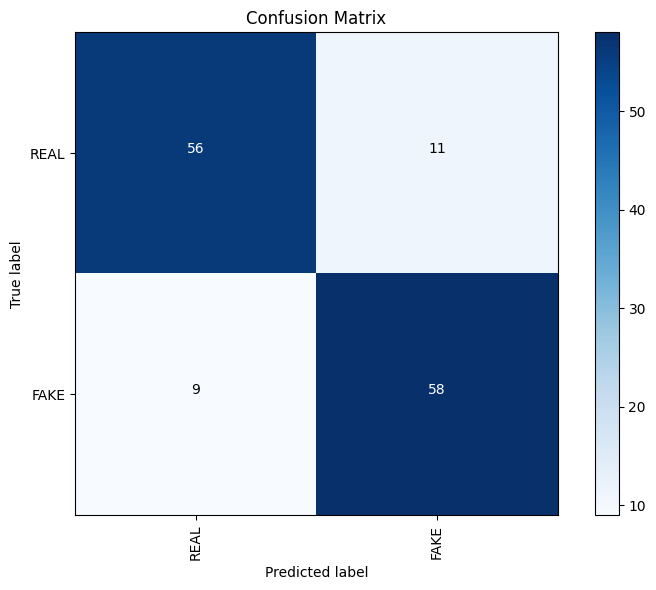


Classification Report:
              precision    recall  f1-score   support

        REAL     0.8615    0.8358    0.8485        67
        FAKE     0.8406    0.8657    0.8529        67

    accuracy                         0.8507       134
   macro avg     0.8511    0.8507    0.8507       134
weighted avg     0.8511    0.8507    0.8507       134

Model saved to vit tiny.pt
Model conversion verified!


In [11]:
# Make predictions on the test dataset
outputs = trainer.predict(test_data)

# Print the metrics from the predictions
print("Prediction Metrics:")
print(outputs.metrics)

# Extract true labels and predicted labels
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix if the number of labels is small
if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

# Save the trained model
trainer.save_model()

# Path to the safetensors file
safetensors_path = "ai_vs_real_image_detection/model.safetensors"

# Load the model from the safetensors file
model_state = load_file(safetensors_path)

# Convert to PyTorch and save as .pt
pt_path = "vit tiny.pt"
torch.save(model_state, pt_path)

print(f"Model saved to {pt_path}")
# Load the .pt file to verify
loaded_state = torch.load(pt_path)

# Check if the state matches
assert model_state.keys() == loaded_state.keys()
print("Model conversion verified!")



## 7.Inferance

In [13]:
# Create an inference pipeline

pipe = pipeline('image-classification', model="ai_vs_real_image_detection", device=-1)

# Example inference on a test image
test_image = test_data[1]["image"]
print("Actual Label:", id2label[test_data[1]["label"]])

# Perform inference and measure time
start_time = time.time()
inference_result = pipe(test_image)
end_time = time.time()

print("Inference Result:", inference_result)
print("Inference Time:", end_time - start_time, "seconds")

Device set to use cpu


Actual Label: REAL
Inference Result: [{'label': 'REAL', 'score': 0.5210098028182983}, {'label': 'FAKE', 'score': 0.12555311620235443}]
Inference Time: 0.0262758731842041 seconds
